In [1]:
# Parts of this code was used from Harper He Code

#### We can view .ipynb file contents right here


In [2]:
# import json
# import os

# # note -- we can look at a .ipynb file as a plain text file right here in Jupyter notebook
# with open ('Lending_Club.ipynb', mode = 'r', encoding = 'utf-8') as f:
#     a = json.load (f)

# print(type(a))

# print(a.keys())

# #print(a)

#### Generating list of notebooks to merge


In [3]:
# # generate list of files to be merged
# notebooks_to_merge = [file for file in os.listdir(os.getcwd()) if file.endswith('.ipynb')]

# # list should be in the order in which you want the notebooks to be merged
# # my notebooks are labeled 1.ipynb, 2.ipynb... in the order I want
# notebooks_to_merge.sort()

# print(notebooks_to_merge)

# del notebooks_to_merge[2:4]
# print(notebooks_to_merge)

#### Generate combined .ipynb file


In [4]:
# def combine_ipynb_files(list_of_notebooks, combined_file_name):
    
#     '''
#     parameters:
#     `list_of_notebooks` is an ordered list of your .ipynb files to be merged
#     `combined_file_name` is the name of your combined .ipynb file which will be generated by this function
    
#     returns: the filepath of the new file
#     '''
    
#     with open (notebooks_to_merge[0], mode = 'r', encoding = 'utf-8') as f:
#         a = json.load (f)
    
#     for notebook in notebooks_to_merge[1:]:
#         with open (notebook, mode = 'r', encoding = 'utf-8') as f:
#             b = json.load(f)
#             a['cells'].extend (b['cells']) 
#                 # extend here, not append, so that each dictionary in b['cells']
#                 # is added to new dictionary in a['cells']

#     with open(combined_file_name, mode='w', encoding='utf-8') as f:
#         json.dump(a, f)
    
#     print('Generated file: "{}".'.format(combined_file_name))
    
#     return (os.path.realpath(combined_file_name))

# combine_ipynb_files(notebooks_to_merge, "combined.ipynb")

In [5]:
# import packages
from pyspark.sql import SparkSession
from pyspark import SparkConf,SparkContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import *

from pyspark.sql.functions import row_number, monotonically_increasing_id
from pyspark.sql import Window

config = SparkConf().setAll([('spark.executor.memory', '8g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','8g')])
# sc.stop()
sc = SparkContext(conf=config)

spark = SparkSession.builder.config(conf=config).getOrCreate()
sc.getConf().getAll()

[('spark.driver.host', 'LAPTOP-UP2IV74A.home'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.cores.max', '3'),
 ('spark.driver.port', '51637'),
 ('spark.app.id', 'local-1587533483900'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.memory', '8g'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.memory', '8g'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.cores', '3'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
# expand the output display to see more columns of a pandas DataFrame
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


In [7]:
# This is a function for checking the shape and size
def size_shape(df):
    print("rows:",df.count())
    print("columns:",len(df.columns))

In [8]:
# Read the dataset
df = spark.read.csv('C:\\Users\\tigerman381\\Downloads\\lending-club-loan-data\\loan.csv', header=True, inferSchema=True)

In [9]:
# take a look at the first 10 rows
# df_pd = df.limit(10).toPandas()
# display(df_pd.head())

In [10]:
# check how many records for each loan status
# df_bystatus=df.groupby(df.loan_status).count()
# df_bystatus.show()

In [11]:
# show all the column names
# df.columns

In [12]:
# check the shape of df
# print("rows:",df.count())
# print("columns:",len(df.columns))

# size_shape(df)

In [13]:
# check the number of Nan or Null for each column
#As per our objective, Filtering only the columns required
current_df = df.filter(col('loan_status').isin(['Late (31-120 days)','Charged Off','Late (16-30 days)','Current']))
#Renaming the Late values into a single late
current_df = current_df.withColumn("loan_status", \
              when(current_df["loan_status"].isin(['Late (31-120 days)','Late (16-30 days)','Current']),'Not Charged Off').otherwise(current_df["loan_status"]))

#Our dataset with only the desired columns values (Charged off, Not Charged Off)
print(current_df.groupby(current_df.loan_status).count().show())



+---------------+------+
|    loan_status| count|
+---------------+------+
|Not Charged Off|945329|
|    Charged Off|261654|
+---------------+------+

None


In [14]:
#Contains the nas present in all the columns in the dataset. We are planning to remove those coluomns with more than 50%Nas
# checkna_pd = current_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in current_df.columns]).toPandas()
# checkna_pd

# current_df.select([c for c in checkna_pd.columns])

In [15]:
#https://stackoverflow.com/questions/51322445/how-to-drop-all-columns-with-null-values-in-a-pyspark-dataframe - include in our references

#Creating a dataframe which has the count of Nas of each column
checkna = current_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in current_df.columns])
#Selecting the columns with NA values not greater than 50%
No_of_rows = current_df.count()
checkna_greater_than_50 = checkna.select([when(fn.col(c)<(No_of_rows*0.50),c).alias(c) for c in checkna.columns])


def drop_null_columns(df):
    """
    This function drops all columns which contain null values.
    :param df: A PySpark DataFrame
    """
    null_counts = df.select([fn.count(fn.when(fn.col(c).isNull()|isnan(fn.col(c)), c)).alias(c) for c in df.columns]).collect()[0].asDict()
    to_drop = [k for k, v in null_counts.items() if v > 0]
    df = df.drop(*to_drop)
    return df

# Using the function to find the list of columns with less than 50%Na values
final_cols = drop_null_columns(checkna_greater_than_50)
current_df1 = current_df.select([fn.col(c) for c in final_cols.columns])

#selecting our dataframe with the final cols


In [16]:
# Benji Explore Columns 1-25

In [17]:
part1=current_df1.select(current_df1.columns[0:25])
#part1.columns
# part1.limit(5).toPandas()

In [18]:
# Dropping columns that have date or will not use in analysis
# drop the cols
drop_var=['issue_d','zip_code','earliest_cr_line']
part1=part1.drop(*drop_var)
# print(size_shape(part1))
# part1.limit(5).toPandas()

In [19]:
# part1.printSchema()

In [20]:
# check the summary of each col
# part1.describe().toPandas().T

In [21]:
# check the missing values
# checkna_part1 = part1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part1.columns])
# checkna_part1.toPandas()

### Columns with missing values | the number of missing values | explanation of the type of data
emp_title      | 105,247 | The job title supplied by the Borrower when applying for the loan.*

title          | 12,520 | The loan title provided by the borrower

addr_state     | 1 | The state provided by the borrower in the loan application

dti            | 1,456 | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

delinq_2yrs    | 1 | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

inq_last_6mths | 1 | The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

open_acc       | 5 | The number of open credit lines in the borrower's credit file.


In [22]:
# Lets look at the columns thave null values

In [23]:
# print(part1.groupby(part1.emp_title).count().show())
# print(part1.groupby(part1.addr_state).count().show())
# print(part1.groupby(part1.dti).count().show())
# print(part1.groupby(part1.delinq_2yrs).count().show())



In [24]:
# print(part1.groupby(part1.inq_last_6mths).count().show())
# print(part1.groupby(part1.open_acc).count().show())


In [25]:
# CHeck the columns to see if they are categories
# print(part1.groupby(part1.purpose).count().show())
# print(part1.groupby(part1.pymnt_plan).count().show())
# print(part1.groupby(part1.verification_status).count().show())


In [26]:
# Check the columns to see if they are categories
# print(part1.groupby(part1.term).count().show())
# print(part1.groupby(part1.grade).count().show())
# print(part1.groupby(part1.sub_grade).count().show())
# print(part1.groupby(part1.home_ownership).count().show())


In [27]:
# Make the columns into categories

cat_col=['term','grade','sub_grade','home_ownership','verification_status','loan_status','pymnt_plan']
part1_cat_col=part1.select(cat_col)
# part1_cat_col.printSchema()

In [28]:
# Now we had columns that had bad data but casting the correct type should solve issue

In [29]:
# After looking at the values, we have some more columns to drop
drop_var_2=['emp_title',"title",'purpose','emp_length','addr_state']
part1=part1.drop(*drop_var_2)
# print(size_shape(part1))
# part1.limit(5).toPandas()

Let's look at changing the numerical cols to the right type

In [30]:
part1_num_col=part1.drop(*cat_col)

In [31]:
# part1_num_col.printSchema()

In [32]:
part1 = part1.withColumn('loan_amnt', part1['loan_amnt'].cast(FloatType()))
part1 = part1.withColumn('funded_amnt', part1['funded_amnt'].cast(FloatType()))
part1 = part1.withColumn('funded_amnt_inv', part1['funded_amnt_inv'].cast(FloatType()))
part1 = part1.withColumn('int_rate',part1['int_rate'].cast(FloatType()))
part1 = part1.withColumn('installment', part1['installment'].cast(FloatType()))
part1 = part1.withColumn('annual_inc', part1['annual_inc'].cast(FloatType()))
part1 = part1.withColumn('dti', part1['dti'].cast(FloatType()))
part1 = part1.withColumn('delinq_2yrs', part1['delinq_2yrs'].cast(IntegerType()))
part1 = part1.withColumn('inq_last_6mths', part1['inq_last_6mths'].cast(IntegerType()))
part1 = part1.withColumn("open_acc",part1["open_acc"].cast(IntegerType()))


In [33]:
# part1.printSchema()

In [34]:
# part1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part1.columns]).toPandas()

### Columns with missing values | the number of missing values | explanation of the type of data

dti            | 1,489 | A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

delinq_2yrs    | 31 | The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years

inq_last_6mths | 24 | The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

open_acc       | 23 | The number of open credit lines in the borrower's credit file.


In [35]:
# Lets fill in the values that are missing with the mean value

dti_mean=part1.select(fn.avg('dti')).collect()
part1 = part1.na.fill({'dti':dti_mean[0][0]})

delinq_2yrs_mean=part1.select(fn.avg('delinq_2yrs')).collect()
part1 = part1.na.fill({'delinq_2yrs':delinq_2yrs_mean[0][0]})

inq_last_6mths_mean=part1.select(fn.avg('inq_last_6mths')).collect()
part1 = part1.na.fill({'inq_last_6mths':inq_last_6mths_mean[0][0]})

open_acc_mean=part1.select(fn.avg('open_acc')).collect()
part1 = part1.na.fill({'open_acc':open_acc_mean[0][0]})

In [36]:
# Recheck for missing values
part1.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part1.columns]).toPandas()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# size_shape(part1)

In [38]:
# part1.describe().toPandas().T

In [39]:
# # Convert string to index label using the StringIndexer
# cat_col_list=['term','grade','sub_grade','home_ownership','verification_status','loan_status','pymnt_plan']
# stringIndexer = feature.StringIndexer(inputCols=[cols for cols in cat_col_list],
#                                       outputCols=["encoded_" + cols for cols in cat_col_list])

In [40]:
# Lets add the index column to be used later before we have to combine all the cleaned dataframes by index value

In [41]:
part1 = part1.withColumn(
    "index",
    row_number().over(Window.orderBy(monotonically_increasing_id()))-1
)


In [42]:
# size_shape(part1)

In [43]:
# part1.describe().toPandas().T

In [44]:
# numeric_cols

In [45]:
# define the VectorAssembler object
# va = feature.VectorAssembler(inputCols=[cols for cols in numeric_cols], outputCol="features")
# define the StandardScaler object
# sScaler = feature.StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")

Define the pipeline which contains 3 stages: stringindexer, VectorAssembler and StandardScaler

In [46]:
# part1_pipe=Pipeline(stages=[stringIndexer, va, sScaler])

Fit the pipeline

In [47]:
# fitted_part1 = part1_pipe.fit(part1)

Apply the pipeline

In [48]:
# transformed_part1 = fitted_part1.transform(part1)

In [49]:
# transformed_part1.limit(5).toPandas()

Using Pyspark to read the dataset and check missing values.

26-50 Columns

In [50]:
part2=current_df1.select(current_df1.columns[25:50])
# part2.columns
# part2.limit(5).toPandas()

Drop date cols

In [51]:
# drop the cols
date_var=['last_pymnt_d','next_pymnt_d','last_credit_pull_d']
part2=part2.drop(*date_var)
print(size_shape(part2))
part2.limit(5).toPandas()

rows: 1206983
columns: 22
None


,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m
0,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,84.92,0,1,Individual,0,0,16901,2
1,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,777.23,0,1,Individual,0,1208,321915,4
2,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,180.69,0,1,Individual,0,0,110299,0
3,0,5468,78.1,13,w,3831.93,3831.93,286.71,286.71,168.07,118.64,0.0,0.0,0.0,146.51,0,1,Individual,0,686,305049,1
4,0,829,3.6,26,w,29339.02,29339.02,1423.21,1423.21,660.98,762.23,0.0,0.0,0.0,731.78,0,1,Individual,0,0,116007,3


In [52]:
# part2.printSchema()

In [53]:
# check the summary of each col
part2.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
pub_rec,1206975,0.1890756536458096,0.5624775092187297,PAYING DEBIT OFF.<br/>SLOW--BUT SURE.<br/> Borrower added on 06/02/10 > JUST A MAN,debt_consolidation
revol_bal,1206977,16807.967260173642,22685.863720159345,LOOKING FOR A HAND-UP,To be rewarded with reasonable terms...
revol_util,1205863,49.61285204510645,25.884634838940773,and -- with the support of the members of the Lending Club -- we will prevail. Thank you for being a part of our future.<br/> Borrower added on 05/24/10 > Here is some additional information about our company,Mar-1994
total_acc,1206981,23.450838130462017,42.4613450933239,and the work we do.<br/><br/>We are in the marketing research and consulting business. Our main task is to speak with customers,small_business
initial_list_status,1206980,926.0172727272726,3263.110236056832,"IN ME. .<br/>""",w
out_prncp,1206978,8245.914858687509,8619.409939480662,but now I am completely back on track & am doing whatever I can to raise my credit score back up,f
out_prncp_inv,1206975,8244.153263444356,8618.754491613367,but in a nutshell we provide direct-from-the-customer data,f
total_pymnt,1206978,7857.123649318276,7372.222174135592,and opinions,w
total_pymnt_inv,1206981,7852.0274051305105,7369.046643175955,extremely rare to miss work.<br/><br/>It's extremely late,f


In [54]:
# check the missing values
checkna_part2 = part2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part2.columns])
checkna_part2.toPandas()

,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m
0,8,6,1120,2,3,5,8,5,2,3,1,2,2,2,1,15,8,12,18,10302,10299,206300


Cope with 3 categorical variables: 'initial_list_status', 'application_type', 'policy_code'

In [55]:
cat_col=['initial_list_status', 'application_type','policy_code']
part2_cat_col=part2.select(cat_col)
part2_cat_col.printSchema()

root
 |-- initial_list_status: string (nullable = true)
 |-- application_type: string (nullable = true)
 |-- policy_code: string (nullable = true)



In [56]:
part2=part2.filter("initial_list_status in ('w','f')")
part2=part2.filter("application_type in ('Individual','Joint App')")
part2=part2.filter("policy_code in ('1','2')")
# part2.select(fn.countDistinct("initial_list_status")).show() returns 2
# part2.select("application_type").distinct().show() returns 'Joint App' and 'Individual'

In [57]:
# part2.groupBy("application_type").count().orderBy("count",ascending=False).show()

In [58]:
# part2.groupBy("initial_list_status").count().orderBy("count",ascending=False).show()

In [59]:
part2.groupBy("policy_code").count().orderBy("count",ascending=False).show()

+-----------+-------+
|policy_code|  count|
+-----------+-------+
|          1|1206949|
+-----------+-------+



In this case, the variable 'policy_code' should be dropped because all the samples belong to one category, which doesn't provide any useful information for classification.

In [60]:
# current_df.groupBy("policy_code").count().orderBy("count",ascending=False).show()

In [61]:
part2=part2.drop("policy_code")

In [62]:
# part2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part2.columns]).toPandas()

Cope with numerical variables

In [63]:
part2_num_col=part2.drop(*cat_col)

In [64]:
# part2_num_col.printSchema()

Let's start with 'pub_rec' variable

In [65]:
# how many distinct values in pub_rec feature
part2.select(fn.countDistinct("pub_rec")).show()
# number of samples that have pub_rec
# part2.filter(fn.col('pub_rec')!=0).count() returns 185562

+-----------------------+
|count(DISTINCT pub_rec)|
+-----------------------+
|                     35|
+-----------------------+



In [66]:
# print the distinct values 
# part2.select('pub_rec').distinct().show(52)

In [67]:
# # REPLACE 11.59 15.31 etc
# # [0-9]+\.[0-9]+
# part2=part2.withColumn('pub_rec',fn.regexp_replace(fn.col("pub_rec"), "[0-9]+\.[0-9]+", "null"))

# # remove strings
# # ^[\D]+.*$
# part2=part2.withColumn('pub_rec',fn.regexp_replace(fn.col("pub_rec"), "^[\D]+.*$", "null"))

# # remove 120XX
# # (^.*[\D]+$)
# part2=part2.withColumn('pub_rec',fn.regexp_replace(fn.col("pub_rec"), "(^.*[\D]+$)", "null"))

# part2.select(fn.countDistinct("pub_rec")).show()

In [68]:
part2.describe('pub_rec').show()

+-------+-------------------+
|summary|            pub_rec|
+-------+-------------------+
|  count|            1206949|
|   mean|0.18891601882101067|
| stddev| 0.5552736651970246|
|    min|                  0|
|    max|                  9|
+-------+-------------------+



In [69]:
part2.describe('revol_bal').show()

+-------+------------------+
|summary|         revol_bal|
+-------+------------------+
|  count|           1206949|
|   mean|16808.217865046492|
| stddev| 22685.94006979832|
|    min|                 0|
|    max|             99996|
+-------+------------------+



We conver the data type of each col to integer or float

In [70]:
part2 = part2.withColumn('pub_rec', part2['pub_rec'].cast(IntegerType()))
part2 = part2.withColumn('revol_bal', part2['revol_bal'].cast(FloatType()))
part2 = part2.withColumn('revol_util',part2['revol_util'].cast(FloatType()))
part2 = part2.withColumn('total_acc', part2['total_acc'].cast(IntegerType()))
part2 = part2.withColumn('out_prncp', part2['out_prncp'].cast(FloatType()))
part2 = part2.withColumn('out_prncp_inv', part2['out_prncp_inv'].cast(FloatType()))
part2 = part2.withColumn('total_pymnt', part2['total_pymnt'].cast(FloatType()))
part2 = part2.withColumn('total_pymnt_inv', part2['total_pymnt_inv'].cast(FloatType()))
part2 = part2.withColumn('total_rec_prncp', part2['total_rec_prncp'].cast(FloatType()))
part2 = part2.withColumn('total_rec_int', part2['total_rec_int'].cast(FloatType()))
part2 = part2.withColumn('total_rec_late_fee', part2['total_rec_late_fee'].cast(FloatType()))
part2 = part2.withColumn('recoveries', part2['recoveries'].cast(FloatType()))
part2 = part2.withColumn('collection_recovery_fee', part2['collection_recovery_fee'].cast(FloatType()))
part2 = part2.withColumn('last_pymnt_amnt', part2['last_pymnt_amnt'].cast(FloatType()))
part2 = part2.withColumn('collections_12_mths_ex_med', part2['collections_12_mths_ex_med'].cast(IntegerType()))
part2 = part2.withColumn('acc_now_delinq', part2['acc_now_delinq'].cast(IntegerType()))
part2 = part2.withColumn("open_acc_6m",part2["open_acc_6m"].cast(IntegerType()))
part2 = part2.withColumn("tot_coll_amt",part2["tot_coll_amt"].cast(FloatType()))
part2 = part2.withColumn("tot_cur_bal",part2["tot_cur_bal"].cast(FloatType()))

In [71]:
part2.printSchema()

root
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: float (nullable = true)
 |-- revol_util: float (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- initial_list_status: string (nullable = true)
 |-- out_prncp: float (nullable = true)
 |-- out_prncp_inv: float (nullable = true)
 |-- total_pymnt: float (nullable = true)
 |-- total_pymnt_inv: float (nullable = true)
 |-- total_rec_prncp: float (nullable = true)
 |-- total_rec_int: float (nullable = true)
 |-- total_rec_late_fee: float (nullable = true)
 |-- recoveries: float (nullable = true)
 |-- collection_recovery_fee: float (nullable = true)
 |-- last_pymnt_amnt: float (nullable = true)
 |-- collections_12_mths_ex_med: integer (nullable = true)
 |-- application_type: string (nullable = true)
 |-- acc_now_delinq: integer (nullable = true)
 |-- tot_coll_amt: float (nullable = true)
 |-- tot_cur_bal: float (nullable = true)
 |-- open_acc_6m: integer (nullable = true)



In [72]:
part2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part2.columns]).toPandas()

,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m
0,0,0,1115,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,10285,10285,206280


Now let's cope with the columns with missing values:revol_util, collections_12_mths_ex_med, tot_coll_amt, tot_cur_bal, open_acc_6m <br>
By replacing the missing values with the mean values

In [73]:
part2.describe('revol_util').show()

+-------+-----------------+
|summary|       revol_util|
+-------+-----------------+
|  count|          1205834|
|   mean|49.60215702112277|
| stddev|24.76317095036885|
|    min|              0.0|
|    max|            366.6|
+-------+-----------------+



In [74]:
revol_util_mean=part2.select(fn.avg('revol_util')).collect()
revol_util_mean[0][0]

49.60215702112277

In [75]:
part2 = part2.na.fill({'revol_util':revol_util_mean[0][0]})

In [76]:
# part2.select([count(when(isnan('revol_util'),True))]).show()
# part2.select([count(when(col('revol_util').isNull(),True))]).show()
part2.select([count(when(isnan('revol_util') | col('revol_util').isNull() , True))]).show()

+--------------------------------------------------------------------------+
|count(CASE WHEN (isnan(revol_util) OR (revol_util IS NULL)) THEN true END)|
+--------------------------------------------------------------------------+
|                                                                         0|
+--------------------------------------------------------------------------+



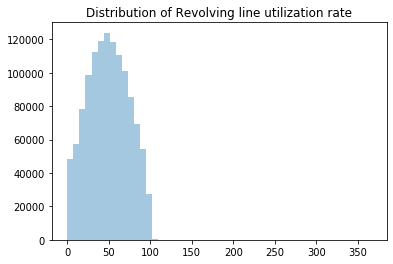

In [77]:
sns.distplot(part2.select('revol_util').collect(),kde=False).set_title('Distribution of Revolving line utilization rate');

In [78]:
# part2.select('revol_util').toPandas()

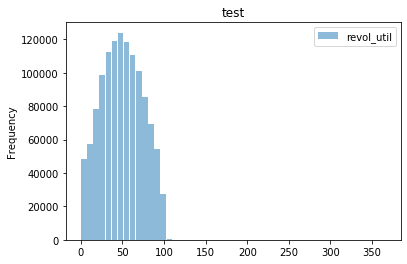

In [79]:
part2.select('revol_util').toPandas().plot.hist(bins=50, rwidth=0.9, alpha=0.5, title='test');

In [80]:
tot_coll_amt_mean=part2.select(fn.avg('tot_coll_amt')).collect()
part2 = part2.na.fill({'tot_coll_amt':tot_coll_amt_mean[0][0]})

In [81]:
tot_cur_bal_mean=part2.select(fn.avg('tot_cur_bal')).collect()
part2 = part2.na.fill({'tot_cur_bal':tot_cur_bal_mean[0][0]})

In [82]:
open_acc_6m_mean=part2.select(fn.avg('open_acc_6m')).collect()
part2 = part2.na.fill({'open_acc_6m':open_acc_6m_mean[0][0]})

In [83]:
collections_12_mths_ex_med_mean=part2.select(fn.avg('collections_12_mths_ex_med')).collect()
part2 = part2.na.fill({'collections_12_mths_ex_med':collections_12_mths_ex_med_mean[0][0]})

In [84]:
#part2.describe('tot_coll_amt').show()

In [85]:
#part2.describe('tot_cur_bal').show()

In [86]:
#part2.describe('open_acc_6m').show()

In [87]:
#part2.groupBy("open_acc_6m").count().orderBy("count",ascending=False).show()

In [88]:
# # check the missing values
# checkna_part2 = part2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part2.columns])
# checkna_part2.toPandas()

In [89]:
# part2.printSchema()

Now we do not have any missing values in these columns

In [90]:
part2.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in part2.columns]).toPandas()

,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [91]:
size_shape(part2)

rows: 1206949
columns: 21


In [92]:
part2.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
pub_rec,1206949,0.18891601882101067,0.5552736651970246,0,86
revol_bal,1206949,16808.217865046492,22685.94006979832,0.0,2559552.0
revol_util,1206949,49.60215702165087,24.751729978833588,0.0,366.6
total_acc,1206949,23.37079445776085,11.941722677905858,2,176
initial_list_status,1206949,None,None,f,w
out_prncp,1206949,8246.047815595506,8619.423099998028,0.0,40000.0
out_prncp_inv,1206949,8244.196088209352,8618.689220779683,0.0,40000.0
total_pymnt,1206949,7857.2732358664325,7372.212777604972,0.0,61947.53
total_pymnt_inv,1206949,7852.147555765605,7369.027624445597,0.0,61947.53


In [93]:
# Now lets add the index to the part2 cleaned dataframe

In [94]:
part2 = part2.withColumn(
    "index",
    row_number().over(Window.orderBy(monotonically_increasing_id()))-1
)

In [95]:
size_shape(part2)

rows: 1206949
columns: 22


In [96]:
df3 = part1.join(part2, "index", "outer")
df3.limit(5).toPandas()

,index,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m
0,0,2500.0,2500.0,2500.0,36 months,13.560000,84.919998,C,C1,RENT,55000.0,Not Verified,Not Charged Off,n,18.24,0,1,9,1,4341.0,10.300000,34,w,2386.020020,2386.020020,167.020004,167.020004,113.980003,53.040001,0.0,0.0,0.0,84.919998,0,Individual,0,0.0,16901.0,2
1,1,30000.0,30000.0,30000.0,60 months,18.940001,777.229980,D,D2,MORTGAGE,90000.0,Source Verified,Not Charged Off,n,26.52,0,0,13,1,12315.0,24.200001,44,w,29387.750000,29387.750000,1507.109985,1507.109985,612.250000,894.859985,0.0,0.0,0.0,777.229980,0,Individual,0,1208.0,321915.0,4
2,2,5000.0,5000.0,5000.0,36 months,17.969999,180.690002,D,D1,MORTGAGE,59280.0,Source Verified,Not Charged Off,n,10.51,0,0,8,0,4599.0,19.100000,13,w,4787.209961,4787.209961,353.890015,353.890015,212.789993,141.100006,0.0,0.0,0.0,180.690002,0,Individual,0,0.0,110299.0,0
3,3,4000.0,4000.0,4000.0,36 months,18.940001,146.509995,D,D2,MORTGAGE,92000.0,Source Verified,Not Charged Off,n,16.74,0,0,10,0,5468.0,78.099998,13,w,3831.929932,3831.929932,286.709991,286.709991,168.070007,118.639999,0.0,0.0,0.0,146.509995,0,Individual,0,686.0,305049.0,1
4,4,30000.0,30000.0,30000.0,60 months,16.139999,731.780029,C,C4,MORTGAGE,57250.0,Not Verified,Not Charged Off,n,26.35,0,0,12,0,829.0,3.600000,26,w,29339.019531,29339.019531,1423.209961,1423.209961,660.979980,762.229980,0.0,0.0,0.0,731.780029,0,Individual,0,0.0,116007.0,3


Now let's converts string to index (labels) using the StringIndexer 

In [97]:
# categorical_cols = ['initial_list_status','application_type']
# stringIndexer = feature.StringIndexer(inputCols=[cols for cols in categorical_cols],
#                                       outputCols=["encoded_" + cols for cols in categorical_cols])

The below codes are to check if this object works

In [98]:
# part2_SI=stringIndexer.fit(part2).transform(part2)

In [99]:
# part2_SI.describe('encoded_initial_list_status').show()

In [100]:
# part2_SI.describe('encoded_application_type').show()

Now let's scale the numeric variables

In [101]:
# numeric_cols = [cols for cols in part2.columns if cols not in categorical_cols]

In [102]:
# numeric_cols

In [103]:
# len(numeric_cols)

It turned out that StandardScaler can only take one column as input columns so we have to Assemble numeric columns to one column

In [104]:
# # define the VectorAssembler object
# va = feature.VectorAssembler(inputCols=[cols for cols in numeric_cols], outputCol="features")
# # define the StandardScaler object
# sScaler = feature.StandardScaler(withMean=True, withStd=True, inputCol="features", outputCol="scaled_features")

In [105]:
# standardScaler = feature.StandardScaler(withMean=True, withStd=True, inputCols=[cols for cols in numeric_cols],
#                                       outputCols=["scaled_" + cols for cols in numeric_cols])

Define the pipeline which contains 3 stages: stringindexer, VectorAssembler and StandardScaler

In [106]:
# part2_pipe=Pipeline(stages=[stringIndexer, va, sScaler])

Fit the pipeline

In [107]:
# fitted_part2 = part2_pipe.fit(part2)

Apply the pipeline

In [108]:
# transformed_part2 = fitted_part2.transform(part2)

In [109]:
# transformed_part2.limit(5).toPandas()

Using Pyspark to read the dataset and check missing values.

In [110]:
part4 = current_df1.select(current_df1.columns[76::1])
# Displaying the dataframe in pandas
# pd.set_option('display.max_columns', None)  
# pd.set_option('display.max_colwidth',-1)
part4.toPandas().head(5)

,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2.0,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,4.0,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,14.0,0.0,0.0,3.0,3.0,3.0,4.0,6.0,7.0,3.0,8.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,5.0,0.0,1.0,2.0,1.0,2.0,7.0,2.0,3.0,2.0,10.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,13.0,0.0,2.0,2.0,3.0,8.0,9.0,6.0,15.0,2.0,12.0,0.0,0.0,0.0,5.0,92.3,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N


In [111]:
part4.printSchema()

root
 |-- mths_since_recent_inq: integer (nullable = true)
 |-- num_accts_ever_120_pd: integer (nullable = true)
 |-- num_actv_bc_tl: integer (nullable = true)
 |-- num_actv_rev_tl: integer (nullable = true)
 |-- num_bc_sats: integer (nullable = true)
 |-- num_bc_tl: integer (nullable = true)
 |-- num_il_tl: integer (nullable = true)
 |-- num_op_rev_tl: integer (nullable = true)
 |-- num_rev_accts: integer (nullable = true)
 |-- num_rev_tl_bal_gt_0: integer (nullable = true)
 |-- num_sats: integer (nullable = true)
 |-- num_tl_120dpd_2m: integer (nullable = true)
 |-- num_tl_30dpd: integer (nullable = true)
 |-- num_tl_90g_dpd_24m: integer (nullable = true)
 |-- num_tl_op_past_12m: integer (nullable = true)
 |-- pct_tl_nvr_dlq: double (nullable = true)
 |-- percent_bc_gt_75: double (nullable = true)
 |-- pub_rec_bankruptcies: integer (nullable = true)
 |-- tax_liens: integer (nullable = true)
 |-- tot_hi_cred_lim: integer (nullable = true)
 |-- total_bal_ex_mort: integer (nullable = tr

In [112]:
#Using count distinct to check about the columns and ascertain its type accordingly
# part4.select([fn.countDistinct(c).alias(c) for c in part4.columns]).toPandas().T
 

In [113]:
# check the summary of each col
# part4.describe().toPandas().T

In [114]:
# Using count distinct to check about the columns and ascertain its type accordingly 
# - whether categorical,float ,integer..etc
Distinctcount4 = part4.select([fn.countDistinct(c).alias(c) for c in part4.columns])

# Distinct count Converting to Pandas(So it computes faster)
DC4= Distinctcount4.toPandas()

In [115]:
#This is to check for categorical numerical and see if we have weird categories.()
# for col in part4.columns:
#     if DC4[col][0]<1000:
#         print(part4.groupby(col).count().show())
#     else:
#         continue

In [116]:
# All these values along with NAs should be replaced first - by the mode for categorical columns with less than 1000 
# distinct values
# These are taken from the above output
cols = ['hardship_flag','disbursement_method','debt_settlement_flag']
wrong_val = ['Feb-2019','Individual','Oct-2011','Oct-2016']
cleaned_int_categorical4 = []

numerical_cols4 = []
d = {}

for col,dtype in part4.dtypes:
    
    #Checking that the distinct values less than 1000 to be qualified as a categorical where we replace the values with mode
    if DC4[col][0]<1000:
        if dtype in ['double','int']:
            print(col,dtype)
            part4 = part4.withColumn(col,fn.when(fn.col(col).isin(wrong_val),'null').otherwise(fn.col(col)))
            
            #Converting them to integer, since in my case.. all are integer type category
            part4 = part4.withColumn(col,part4[col].cast(IntegerType()))
            
            #Filling the NAs by the mode
            temp = part4.groupby(fn.col(col)).count()
            
            #Making sure that the grouped mode value is not a null
            mode_value = temp.orderBy(temp['count'].desc()).collect()[0][0]
            if mode_value is None:
                mode_value = temp.orderBy(temp['count'].desc()).collect()[1][0]
            part4 = part4.fillna(mode_value,subset = col)
            print(col,' done')
            cleaned_int_categorical4.append(col)
            
            #Winsorizing the columns
            d[col] = part4.approxQuantile(col,[0.01,0.99],0.25)
            part4 = part4.withColumn(col,fn.when(fn.col(col)<d[col][0],d[col][0]).when(fn.col(col)>d[col][1],d[col][1]).otherwise(fn.col(col)))
            print(col,'winsorising done')
        else:
            continue
                    
    else:
        #This means that they have more than 1000 distinct values and can be treated as Float continous
        print(col,dtype)
        part4 = part4.withColumn(col,fn.when(part4[col].isin(wrong_val),'null').otherwise(part4[col]))
        
        #Casting to float type
        part4 = part4.withColumn(col,part4[col].cast(FloatType()))
        
        #Replacing the float type value nas with its mean
        mean_val = part4.select(fn.avg(fn.col(col))).collect()[0][0]
        part4 = part4.fillna(mean_val,subset = col)
        
        #Winsorizing the values
        d[col] = part4.approxQuantile(col,[0.01,0.99],0.25)
        part4 = part4.withColumn(col,fn.when(fn.col(col)<d[col][0],d[col][0]).when(fn.col(col)>d[col][1],d[col][1]).otherwise(fn.col(col)))
        print(col,'winsorising done')
        numerical_cols4.append(col)
   
    
#These are the count of Null values in the columns
part4.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in part4.columns]).toPandas().T           


mths_since_recent_inq int
mths_since_recent_inq  done
mths_since_recent_inq winsorising done
num_accts_ever_120_pd int
num_accts_ever_120_pd  done
num_accts_ever_120_pd winsorising done
num_actv_bc_tl int
num_actv_bc_tl  done
num_actv_bc_tl winsorising done
num_actv_rev_tl int
num_actv_rev_tl  done
num_actv_rev_tl winsorising done
num_bc_sats int
num_bc_sats  done
num_bc_sats winsorising done
num_bc_tl int
num_bc_tl  done
num_bc_tl winsorising done
num_il_tl int
num_il_tl  done
num_il_tl winsorising done
num_op_rev_tl int
num_op_rev_tl  done
num_op_rev_tl winsorising done
num_rev_accts int
num_rev_accts  done
num_rev_accts winsorising done
num_rev_tl_bal_gt_0 int
num_rev_tl_bal_gt_0  done
num_rev_tl_bal_gt_0 winsorising done
num_sats int
num_sats  done
num_sats winsorising done
num_tl_120dpd_2m int
num_tl_120dpd_2m  done
num_tl_120dpd_2m winsorising done
num_tl_30dpd int
num_tl_30dpd  done
num_tl_30dpd winsorising done
num_tl_90g_dpd_24m int
num_tl_90g_dpd_24m  done
num_tl_90g_dpd_24m 

,0
mths_since_recent_inq,0
num_accts_ever_120_pd,0
num_actv_bc_tl,0
num_actv_rev_tl,0
num_bc_sats,0
num_bc_tl,0
num_il_tl,0
num_op_rev_tl,0
num_rev_accts,0
num_rev_tl_bal_gt_0,0


In [117]:
#Now for the string Cols - Since those are categorical, I will replace it by the value 'unknown'. Since the fraction of Null is negligible
string_cols4 = ['disbursement_method','debt_settlement_flag','hardship_flag']
part4 = part4.fillna('unknown',subset = string_cols4)
part4.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in part4.columns]).toPandas().T    

,0
mths_since_recent_inq,0
num_accts_ever_120_pd,0
num_actv_bc_tl,0
num_actv_rev_tl,0
num_bc_sats,0
num_bc_tl,0
num_il_tl,0
num_op_rev_tl,0
num_rev_accts,0
num_rev_tl_bal_gt_0,0


In [118]:
# cleaned_dataframe_part4 = part4

In [119]:
# Lets add the index to part4 

In [120]:
part4 = part4.withColumn(
    "index",
    row_number().over(Window.orderBy(monotonically_increasing_id()))-1
)

In [121]:
# part4_pd = part4.describe().toPandas()
# part4_pd 

In [122]:
# all_cols = []
# # Now that cleaning is done ; Let us start with the pipeline
# # Since all the categorical columns are numbers

# cat_coded4_cols = []
# string_cols4 = []
# for c in cleaned_int_categorical4:
#     print(c)
#     part4 = Pipeline(stages = [feature.OneHotEncoder(inputCol = c,outputCol = c+'catcoded4')]).fit(part4).transform(part4)
#     cat_coded4_cols.append(c+'catcoded4')
# for c in string_cols:
#     part4 = Pipeline(stages = [feature.StringIndexer(inputCol = c,outputCol = c+'index4'),
#                               feature.OneHotEncoder(inputCol = c+'index4',outputCol = c+'stringcoded4')]).fit(part4).transform(part4)
#     string_cols4.append(c+'stringcoded4')


In [123]:
# total_cols4 = cat_coded4_cols + string_cols4 + numerical_cols4

# #Use features4 as stages for your modelling needs
# part4_pipe = Pipeline(stages = [feature.VectorAssembler(inputCols = total_cols4,outputCol = 'feature4')])
# part4_pipe.fit(part4).transform(part4).first()
# #For cleaned dataframe - use cleaned_dataframe_part4 ( which is just all columns cleaned )

In [124]:
part3 = current_df1.select(current_df1.columns[50:76:1])
part3.toPandas().head()

,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc
0,2,1,2,2,12560,69,2,7,2137,28,42000,1,11,2,9.0,1878,34360.0,5.9,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0
1,4,2,3,3,87153,88,4,5,998,57,50800,2,15,2,10.0,24763,13761.0,8.3,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0
2,1,0,2,14,7150,72,0,2,0,35,24100,1,5,0,4.0,18383,13800.0,0,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0
3,5,3,5,5,30683,68,0,0,3761,70,7000,2,4,3,5.0,30505,1239.0,75.2,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0
4,5,3,5,4,28845,89,2,4,516,54,23100,1,0,0,9.0,9667,8471.0,8.9,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0


In [125]:
#These are the count of Null values in the columns
part3.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in part3.columns]).toPandas().T

,0
open_act_il,206297
open_il_12m,206304
open_il_24m,206307
mths_since_rcnt_il,240368
total_bal_il,206306
il_util,355256
open_rv_12m,206310
open_rv_24m,206308
max_bal_bc,206309
all_util,206487


In [126]:
#Using count distinct to check about the columns and ascertain its type accordingly - whether categorical,float ,integer..etc
Distinctcount3 = part3.select([fn.countDistinct(c).alias(c) for c in part3.columns])
# Distinctcount Converting to Pandas(So it computes faster)
DC3= Distinctcount3.toPandas()

In [127]:
#This is to check for wrong values & correct them.
# for col in part3.columns:
#     if Distinctcount3.select(fn.col(col)).collect()[0][0]<1000:
#         print(part3.groupby(col).count().show())
#     else:
#         continue

In [128]:
#All these values along with NAs should be replaced first - by the mode for categorical columns with less than 1000 distinct values
#These are taken from the above output - BUT THE PROBLEM HERE IS (ONLY FROM THE TOP 20 ROWS)

wrong_val = ['Feb-2019','Individual','Oct-2011','Oct-2016']
cleaned_int_categorical3 = []

numerical_cols3 = []
d = {}

for col,dtype in part3.dtypes:
    
    #Checking that the distinct values less than 1000 to be qualified as a categorical where we replace the values with mode
    if DC3[col][0]<1000:
        if dtype in ['string','double','int']:
            print(col,dtype)
            #COnverting those wrong values to null
            part3 = part3.withColumn(col,fn.when(fn.col(col).isin(wrong_val),'null').otherwise(fn.col(col)))
            
            #Converting them to integer, since in my case.. all are integer type category
            part3 = part3.withColumn(col,part3[col].cast(IntegerType()))
            
            #Filling the NAs by the mode
            temp = part3.groupby(fn.col(col)).count()
            
            #Making sure that the grouped mode value is not a null
            mode_value = temp.orderBy(temp['count'].desc()).collect()[0][0]
            if mode_value is None:
                mode_value = temp.orderBy(temp['count'].desc()).collect()[1][0]
            part3 = part3.fillna(mode_value,subset = col)
            print(col,' done')
            cleaned_int_categorical3.append(col)
            
            #Winsorizing the columns
            d[col] = part3.approxQuantile(col,[0.01,0.99],0.25)
            part3 = part3.withColumn(col,fn.when(fn.col(col)<d[col][0],d[col][0]).when(fn.col(col)>d[col][1],d[col][1]).otherwise(fn.col(col)))
            print(col,'winsorising done')
    else:
        #This means that they have more than 1000 distinct values and can be treated as continous
        print(col,dtype)
        part3 = part3.withColumn(col,fn.when(part3[col].isin(wrong_val),'null').otherwise(part3[col]))
        #Casting to float type
        part3 = part3.withColumn(col,part3[col].cast(FloatType()))
        #Replacing the float type value nas with its mean
        mean_val = part3.select(fn.avg(fn.col(col))).collect()[0][0]
        part3 = part3.fillna(mean_val,subset = col)
        #Winsorizing the values
        d[col] = part3.approxQuantile(col,[0.01,0.99],0.25)
        part3 = part3.withColumn(col,fn.when(fn.col(col)<d[col][0],d[col][0]).when(fn.col(col)>d[col][1],d[col][1]).otherwise(fn.col(col)))
        print(col,'winsorising done')
        numerical_cols3.append(col)
   
    
#These are the count of Null values in the columns
part3.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in part3.columns]).toPandas().T           


open_act_il string
open_act_il  done
open_act_il winsorising done
open_il_12m string
open_il_12m  done
open_il_12m winsorising done
open_il_24m string
open_il_24m  done
open_il_24m winsorising done
mths_since_rcnt_il string
mths_since_rcnt_il  done
mths_since_rcnt_il winsorising done
total_bal_il string
total_bal_il winsorising done
il_util string
il_util  done
il_util winsorising done
open_rv_12m string
open_rv_12m  done
open_rv_12m winsorising done
open_rv_24m string
open_rv_24m  done
open_rv_24m winsorising done
max_bal_bc string
max_bal_bc winsorising done
all_util string
all_util  done
all_util winsorising done
total_rev_hi_lim string
total_rev_hi_lim winsorising done
inq_fi string
inq_fi  done
inq_fi winsorising done
total_cu_tl string
total_cu_tl  done
total_cu_tl winsorising done
inq_last_12m string
inq_last_12m  done
inq_last_12m winsorising done
acc_open_past_24mths int
acc_open_past_24mths  done
acc_open_past_24mths winsorising done
avg_cur_bal string
avg_cur_bal winsorising

,0
open_act_il,0
open_il_12m,0
open_il_24m,0
mths_since_rcnt_il,0
total_bal_il,0
il_util,0
open_rv_12m,0
open_rv_24m,0
max_bal_bc,0
all_util,0


In [129]:
# Lets create an index for part 3

In [130]:
part3 = part3.withColumn(
    "index",
    row_number().over(Window.orderBy(monotonically_increasing_id()))-1
)

In [131]:
# Lets join part 3 and part 4

In [132]:
df4 = part3.join(part4, "index", "outer")
df4.limit(5).toPandas()

,index,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000.0,1.0,11.0,2.0,9.0,1878.0,34360.0,5.900000,0.0,0.0,140.0,212.0,1.0,1.0,0.0,1.0,2.0,0.0,2.0,5.0,3.0,3.0,16.0,7.0,18.0,5.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,1,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800.0,2.0,15.0,2.0,10.0,24763.0,13761.0,8.300000,0.0,0.0,163.0,378.0,4.0,3.0,3.0,4.0,4.0,0.0,2.0,4.0,4.0,9.0,27.0,8.0,14.0,4.0,13.0,0.0,0.0,0.0,6.0,95.0,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,2,1.0,0.0,2.0,14.0,7150.0,72.0,0.0,2.0,0.0,35.0,24100.0,1.0,5.0,0.0,4.0,18383.0,13800.0,0.000000,0.0,0.0,87.0,92.0,15.0,14.0,2.0,77.0,14.0,0.0,0.0,3.0,3.0,3.0,4.0,6.0,7.0,3.0,8.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,3,5.0,3.0,5.0,5.0,30683.0,68.0,0.0,0.0,3761.0,70.0,7000.0,2.0,4.0,3.0,5.0,30505.0,1239.0,75.199997,0.0,0.0,62.0,154.0,64.0,5.0,3.0,64.0,5.0,0.0,1.0,2.0,1.0,2.0,7.0,2.0,3.0,2.0,10.0,0.0,0.0,0.0,3.0,100.0,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,4,5.0,3.0,5.0,4.0,28845.0,89.0,2.0,4.0,516.0,54.0,23100.0,1.0,0.0,0.0,9.0,9667.0,8471.0,8.900000,0.0,0.0,53.0,216.0,2.0,2.0,2.0,2.0,13.0,0.0,2.0,2.0,3.0,8.0,9.0,6.0,15.0,2.0,12.0,0.0,0.0,0.0,5.0,92.0,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N


In [133]:
# Lets join all parts

In [134]:
allParts = df3.join(df4, "index", "outer").drop("index")
# allParts.limit(5).toPandas()

In [135]:
#These are the count of Null values in the columns
allParts.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in allParts.columns])
# allParts.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in allParts.columns]).toPandas()

DataFrame[loan_amnt: bigint, funded_amnt: bigint, funded_amnt_inv: bigint, term: bigint, int_rate: bigint, installment: bigint, grade: bigint, sub_grade: bigint, home_ownership: bigint, annual_inc: bigint, verification_status: bigint, loan_status: bigint, pymnt_plan: bigint, dti: bigint, delinq_2yrs: bigint, inq_last_6mths: bigint, open_acc: bigint, pub_rec: bigint, revol_bal: bigint, revol_util: bigint, total_acc: bigint, initial_list_status: bigint, out_prncp: bigint, out_prncp_inv: bigint, total_pymnt: bigint, total_pymnt_inv: bigint, total_rec_prncp: bigint, total_rec_int: bigint, total_rec_late_fee: bigint, recoveries: bigint, collection_recovery_fee: bigint, last_pymnt_amnt: bigint, collections_12_mths_ex_med: bigint, application_type: bigint, acc_now_delinq: bigint, tot_coll_amt: bigint, tot_cur_bal: bigint, open_acc_6m: bigint, open_act_il: bigint, open_il_12m: bigint, open_il_24m: bigint, mths_since_rcnt_il: bigint, total_bal_il: bigint, il_util: bigint, open_rv_12m: bigint, o

In [136]:
# Check the dimensions of the dataframe
size_shape(allParts)

rows: 1206983
columns: 90


In [137]:
# Drop to rows where the Loan_Status is == "Late"



In [138]:
# Drop rows that have null values

allParts = allParts.filter(allParts["recoveries"]. isNotNull())

In [139]:
#These are the count of Null values in the columns
allParts.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in allParts.columns])

#allParts.select([fn.count(fn.when(fn.isnan(c)|fn.isnull(c),c)).alias(c) for c in allParts.columns]).toPandas()

DataFrame[loan_amnt: bigint, funded_amnt: bigint, funded_amnt_inv: bigint, term: bigint, int_rate: bigint, installment: bigint, grade: bigint, sub_grade: bigint, home_ownership: bigint, annual_inc: bigint, verification_status: bigint, loan_status: bigint, pymnt_plan: bigint, dti: bigint, delinq_2yrs: bigint, inq_last_6mths: bigint, open_acc: bigint, pub_rec: bigint, revol_bal: bigint, revol_util: bigint, total_acc: bigint, initial_list_status: bigint, out_prncp: bigint, out_prncp_inv: bigint, total_pymnt: bigint, total_pymnt_inv: bigint, total_rec_prncp: bigint, total_rec_int: bigint, total_rec_late_fee: bigint, recoveries: bigint, collection_recovery_fee: bigint, last_pymnt_amnt: bigint, collections_12_mths_ex_med: bigint, application_type: bigint, acc_now_delinq: bigint, tot_coll_amt: bigint, tot_cur_bal: bigint, open_acc_6m: bigint, open_act_il: bigint, open_il_12m: bigint, open_il_24m: bigint, mths_since_rcnt_il: bigint, total_bal_il: bigint, il_util: bigint, open_rv_12m: bigint, o

In [140]:
# Check the dimensions of the dataframe
size_shape(allParts)

rows: 1206949
columns: 90


In [141]:
# allParts.describe(string_cols4).show()
# print(allParts.groupby(string_cols4[0]).count().show())
# print(allParts.groupby(string_cols4[1]).count().show())
# print(allParts.groupby(string_cols4[2]).count().show())


In [142]:
# allParts.describe(cleaned_int_categorical4).toPandas().T

In [143]:
# numerical_cols4

In [144]:
# From doing the correlation matrix, we notice that there are some columns that need to be removed from our 

In [145]:
del_cols = ['policy_code','pymnt_plan','url','application_type','acc_now_delinq','emp_title','zip_code','title',
        'installment',
'total_rec_prncp',
'total_rec_int',
'recoveries',
'inq_fi',
'inq_last_12m',
'chargeoff_within_12_mths',
'num_actv_rev_tl',
'num_bc_tl',
'num_op_rev_tl',
'num_tl_op_past_12m',
'percent_bc_gt_75',
'avg_cur_bal',
'total_bc_limit',
'total_il_high_credit_limit']
allParts_dropped = allParts.drop(*del_cols)
print(size_shape(allParts))
print(size_shape(allParts_dropped))

rows: 1206949
columns: 90
None
rows: 1206949
columns: 72
None


#### Here we will make a way to combine all of our work into a logical sequence so that categories can be changed using string indexer and numerical columns can be changed by using standard scaler

In [146]:
# Categorical operations

In [147]:
# The column that we are going to be predicting on needs to change to a numerical value
en_pred = feature.StringIndexer(handleInvalid='skip', inputCol='loan_status', outputCol='encoded_loan_status')

In [148]:
# Convert string to index label using the StringIndexer
cat_col_list=['term','grade','verification_status','pymnt_plan']


In [149]:
categorical_cols = ['initial_list_status','application_type']
for i in cat_col_list:
    if i in del_cols:
        continue
    else:
        categorical_cols.append(i)
categorical_cols_new = []
for i in categorical_cols:
    if i in del_cols:
        continue
    else:
        categorical_cols_new.append(i)
categorical_cols = categorical_cols_new

print(categorical_cols)

stringIndexer = feature.StringIndexer(handleInvalid='skip', inputCols=[cols for cols in categorical_cols],
                                      outputCols=["encoded_" + cols for cols in categorical_cols])

categorical_cols_new = []
for i in categorical_cols:
    if i in del_cols:
        continue
    else:
        categorical_cols_new.append(i)
        
        
categorical_cols = categorical_cols_new
#categorical_cols = categorical_cols[0:4]
categorical_cols

['initial_list_status', 'term', 'grade', 'verification_status']


['initial_list_status', 'term', 'grade', 'verification_status']

In [150]:
# use this feature on columns that are categorical and not ordinal
one_hot_categorical_cols = []
ones = ['sub_grade','home_ownership']

for i in string_cols4:
    one_hot_categorical_cols.append(i)


string_hot = feature.StringIndexer(handleInvalid='skip', inputCols= [cols for cols in ones],
                                      outputCols=["encoded_" + cols for cols in ones])
    
onehot= feature.OneHotEncoder(inputCols=["encoded_" + cols for cols in ones],
                                      outputCols=["onehot_encoded_" + cols for cols in ones])

catHotVA = feature.VectorAssembler(inputCols=["onehot_encoded_" + cols for cols in ones], outputCol="catHotfeatures") # 


In [151]:
colsNonNumeric = ["loan_status"]
    
for i in categorical_cols:
    if i == 'loan_status':
        continue
    else:
        colsNonNumeric.append(i)
    
for i in one_hot_categorical_cols:
    if i == 'loan_status':
        continue
    else:
        colsNonNumeric.append(i)
    

colsNonNumeric

['loan_status',
 'initial_list_status',
 'term',
 'grade',
 'verification_status',
 'disbursement_method',
 'debt_settlement_flag',
 'hardship_flag']

In [152]:
# colsNonNumeric = ["loan_status"]
    
# for i in categorical_cols:
#     colsNonNumeric.append(i)
    
# for i in one_hot_categorical_cols:
#     colsNonNumeric.append(i)
    



In [153]:
# # Need to get all the names of the encoded columns and put them into a list except for the enconded_loan_status
# en_colsNonNumeric = []  # 'onehot_encoded_sub_grade','onehot_encoded_home_ownership'
    
# for i in categorical_cols:
#     en_colsNonNumeric.append("encoded_"+i)
    
# for i in one_hot_categorical_cols:
#     en_colsNonNumeric.append("encoded_"+i)
    


# # catCols  = ["encoded_" + cols for cols in one_hot_categorical_cols]

# # oneCols = ["encoded_" + cols for cols in categorical_cols]

# print(len(en_colsNonNumeric))
# en_colsNonNumeric
# del en_colsNonNumeric[6:8:1]
# print(len(en_colsNonNumeric))
# en_colsNonNumeric

In [154]:
# Numerical Operations

Now let's scale the numeric variables

In [155]:
numeric_cols = [cols for cols in allParts.columns if (cols not in colsNonNumeric) and (cols not in del_cols) and (cols not in ones)]

In [156]:
# numeric_cols = [cols for cols in allParts.columns if cols not in colsNonNumeric]
# numeric_cols

It turned out that StandardScaler can only take one column as input columns so we have to Assemble numeric columns to one column

In [157]:
print(len(numeric_cols))
size_shape(allParts)



62
rows: 1206949
columns: 90


In [158]:
# define the VectorAssembler object
numericVA = feature.VectorAssembler(inputCols=[cols for cols in numeric_cols], outputCol="numfeatures")

#
catVA = feature.VectorAssembler(inputCols=["encoded_" + cols for cols in categorical_cols], outputCol="catfeatures") # 

# define the StandardScaler object
sScaler = feature.StandardScaler(withMean=True, withStd=True, inputCol="numfeatures", outputCol="scaled_features")

# define a Vector assembler that handles all features that need to be scaled
allVA = feature.VectorAssembler(inputCols=['scaled_features','catHotfeatures','catfeatures'], outputCol='final_features') # 'catfeatures'

Define the pipeline which contains 9 stages: stringindexer, VectorAssembler(numeric), StandardScaler, stringIndexer(one_hot_categorical),OneHotEnconder(one_hot_categroical),VectorAssembler(one_hot_categorical),VectorAssembler(categorical), stringIndexer(prediction_col), VectorAssembler(all columns)


In [159]:
allParts_pipe=Pipeline(stages=[stringIndexer, numericVA, sScaler, string_hot, onehot,catHotVA, catVA, en_pred, allVA])



In [160]:
# allParts_pipe=Pipeline(stages=[stringIndexer, onehot, numericVA, sScaler, catVA, en_pred, allVA])
# catVA = feature.VectorAssembler(inputCols=[cols for cols in en_colsNonNumeric], outputCol="catfeatures")
# allParts_pipe=Pipeline(stages=[stringIndexer, numericVA, sScaler, en_pred, allVA])


Fit the pipeline

In [161]:
# All variables in the model 
fitted_allParts = allParts_pipe.fit(allParts)

# Reduced variables in the model
fitted_allParts_dropped = allParts_pipe.fit(allParts_dropped)

Apply the pipeline


In [162]:
# transformed_allParts = fitted_allParts.transform(allParts)
# transformed_allParts.limit(5).toPandas()

transformed_allParts_dropped = fitted_allParts_dropped.transform(allParts_dropped)
# transformed_allParts_dropped.limit(5).toPandas()

# Random Forest For All Features

In [180]:
trainR , testR = allParts_dropped.randomSplit([0.8,0.2],0)

rfR = classification.RandomForestClassifier(featuresCol = 'final_features',labelCol = 'encoded_loan_status',maxBins = 40,maxDepth = 7)
rf_modelR = Pipeline(stages = [allParts_pipe,rfR])
fitted_rf_pipelineR = rf_modelR.fit(trainR)
rf_modelR = fitted_rf_pipelineR.stages[-1]

bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
bceR.evaluate(fitted_rf_pipelineR.transform(testR))
pd.DataFrame(list(zip(allParts_dropped.columns[2:], rf_modelR.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending = False).head(20)

,column,weight
14,revol_bal,0.189613
13,pub_rec,0.148968
28,open_acc_6m,0.124547
27,tot_cur_bal,0.094344
18,out_prncp,0.089755
33,total_bal_il,0.035971
25,collections_12_mths_ex_med,0.033773
32,mths_since_rcnt_il,0.029548
24,last_pymnt_amnt,0.027444
31,open_il_24m,0.025129


In [183]:
bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
bceR.evaluate(fitted_rf_pipelineR.transform(testR))

0.9052877020659782

## Extracting only the 20 features which shall be used for further evaluation

In [188]:
col20_df = pd.DataFrame(list(zip(allParts_dropped.columns[2:], rf_modelR.featureImportances.toArray())),
            columns = ['column', 'weight']).sort_values('weight',ascending = False).head(20)
# Creating a DataFrame with only these 20columns to do further analysis
new_cols = list(col20_df['column'])
spark20_df = allParts_dropped.select([col for col in new_cols]+['loan_status'])
size_shape(spark20_df)


rows: 1206949
columns: 21


### Random Forest  with TOP 20

In [ ]:
#Defining the Pipeline and train_test_split
revised_train , revised_test = spark20_df.randomSplit([0.8,0.2],0)
revised_pipe = Pipeline(stages = [feature.StringIndexer(inputCol = 'grade',outputCol = 'grade_coded'),
                                  feature.StringIndexer(handleInvalid='skip', inputCol='loan_status', outputCol='encoded_loan_status'),
                                  feature.VectorAssembler(inputCols=[cols for cols in new_cols if cols != 'grade']+['grade_coded'],outputCol = 'features') ])


In [189]:
#Since most here are numerical & float


revised_rF = classification.RandomForestClassifier(featuresCol = 'features',labelCol = 'encoded_loan_status')
rf_modelR2 = Pipeline(stages = [revised_pipe,revised_rF])
fitted_rf_pipelineR2 = rf_modelR2.fit(revised_train)
# rf_modelR = fitted_rf_pipelineR2.stages[-1]
bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
bceR.evaluate(fitted_rf_pipelineR2.transform(revised_test))



0.8612481218976634

## Logistic Regression with TOP 20

In [193]:

revised_Lr = classification.LogisticRegression(featuresCol = 'features',labelCol = 'encoded_loan_status')
paramGrid = ParamGridBuilder() \
    .addGrid(revised_Lr.elasticNetParam, [0., 0.01]) \
    .addGrid(revised_Lr.regParam, [0.1, 0.001]) \
    .build()

#Will take 30min to train.. so care
Lr_modelR2 = Pipeline(stages = [revised_pipe,revised_Lr])
evaluator = BinaryClassificationEvaluator(labelCol=revised_Lr.getLabelCol(), rawPredictionCol=revised_Lr.getRawPredictionCol(), numBins=40)
crossval = CrossValidator(estimator=Lr_modelR2, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=2)
final_model_fitted_Lr = crossval.fit(revised_train)

bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
bceR.evaluate(final_model_fitted_Lr.transform(revised_test))

# Full Model



0.8399019483067991

##  Gradiant Boosting Model

In [196]:
gbtR = classification.GBTClassifier(featuresCol = 'features',labelCol = 'encoded_loan_status',maxBins = 40)
gbt_modelR = Pipeline(stages = [revised_pipe,gbtR])
fitted_gbt_pipelineR = gbt_modelR.fit(revised_train)



bceR = BinaryClassificationEvaluator(labelCol = 'encoded_loan_status')
bceR.evaluate(fitted_gbt_pipelineR.transform(revised_test))

0.9012175396099701

### Now let us check all the models and we shall compare and contrast

In [199]:
# The labels be
Labels = fitted_rf_pipelineR2.stages[0].stages[1].labels

['Not Charged Off', 'Charged Off']

In [197]:
from sklearn.metrics import classification_report, confusion_matrix
models = [fitted_rf_pipelineR2,final_model_fitted_Lr,fitted_gbt_pipelineR]
names = ['Random Forest Model with TOP 20','Logistic Regression with TOP 20','GBT with top 20']
for i,model in enumerate(models):
    print(names[i])
    tranformed_test = model.transform(revised_test)
    y_true = tranformed_test.select(['encoded_loan_status']).collect()
    y_pred = tranformed_test.select(['prediction']).collect()
    print(classification_report(y_true, y_pred))
##Here 0 is Not Charged Off, 1 is Charged Off

Random Forest Model with TOP 20
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91    189269
         1.0       0.71      0.61      0.65     52371

    accuracy                           0.86    241640
   macro avg       0.80      0.77      0.78    241640
weighted avg       0.86      0.86      0.86    241640

Logistic Regression with TOP 20
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90    189269
         1.0       0.69      0.42      0.52     52371

    accuracy                           0.83    241640
   macro avg       0.77      0.69      0.71    241640
weighted avg       0.82      0.83      0.82    241640

GBT with top 20
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92    189269
         1.0       0.71      0.66      0.68     52371

    accuracy                           0.87    241640
   macro avg       0.81      0.79      0.80    2

In [201]:
for i,model in enumerate(models):
    print(names[i])
    print('AUC score is '+str(bceR.evaluate(model.transform(revised_test))))
    

Random Forest Model with TOP 20
AUC score is 0.8613061708278025
Logistic Regression with TOP 20
AUC score is 0.8399004005687106
GBT with top 20
AUC score is 0.9012172688327297
